#### Data Preparation & Checkpointing

- Merging the behavioral and player datasets and saving as a master file for the ML pipeline.

In [2]:
import pandas as pd

# 1. Load the two raw files
df_players = pd.read_csv('churn_players.csv')
df_behavior = pd.read_csv('churn_behavior.csv')

# 2. Merge on player_id
df_master = pd.merge(df_players, df_behavior, on='player_id', how='inner')

# 3. Quick Clean: Ensure there are no missing values before ML
df_master = df_master.dropna()

# 4. SAVE the file so it's available for the rest of the notebook
df_master.to_csv('churn_master_data.csv', index=False)

print(f"Success! 'churn_master_data.csv' created with {df_master.shape[0]} rows.")

Success! 'churn_master_data.csv' created with 2000 rows.


#### Machine Learning Environment Setup

- Loading the processed behavioral data for predictive modeling.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load the master dataset
df_master = pd.read_csv('churn_master_data.csv') 

# Select features based on our EDA findings
features = ['total_logins', 'payment_failure_rate', 'avg_bet_size']
X = df_master[features]
y = df_master['churned']

print(f"Ready to train on {X.shape[0]} samples with {len(features)} behavioral features.")

Ready to train on 2000 samples with 3 behavioral features.


#### Training the Random Forest Classifier

- We use a Random Forest model because it captures the non-linear relationship between 'Friction' (Payment Failures) and 'Engagement' (Logins).

In [4]:
# 1. Split into Training (80%) and Testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Initialize the Random Forest
# max_depth=5 prevents 'overfitting' (the model memorizing data rather than learning patterns)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# 3. Fit the model
rf_model.fit(X_train, y_train)

print("Model Training Complete.")

Model Training Complete.


#### Model Evaluation: Precision & Recall

- In iGaming churn, 'Recall' is vital. We want to make sure we catch as many potential churners as possible, even if we accidentally flag a few active players.

 Classification Report 
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       285
           1       0.77      0.94      0.85       115

    accuracy                           0.90       400
   macro avg       0.87      0.91      0.89       400
weighted avg       0.92      0.90      0.91       400



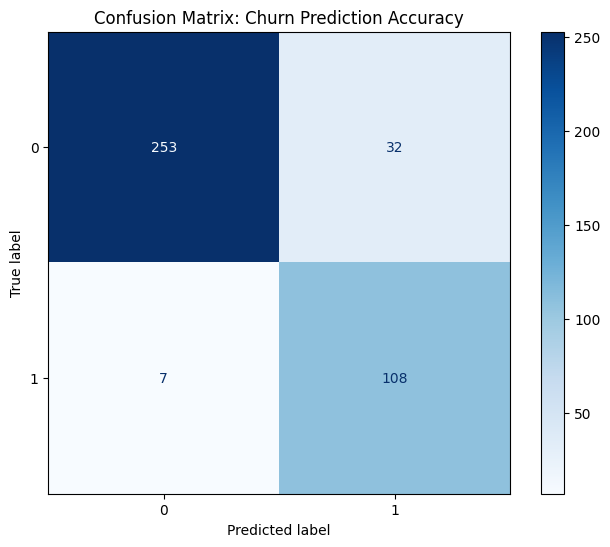

In [6]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Print Detailed Report
print(" Classification Report ")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap='Blues', ax=ax)
plt.title('Confusion Matrix: Churn Prediction Accuracy')
plt.show()

#### Feature Importance Ranking

- This tells the business exactly which behavior is the strongest predictor of a player leaving.

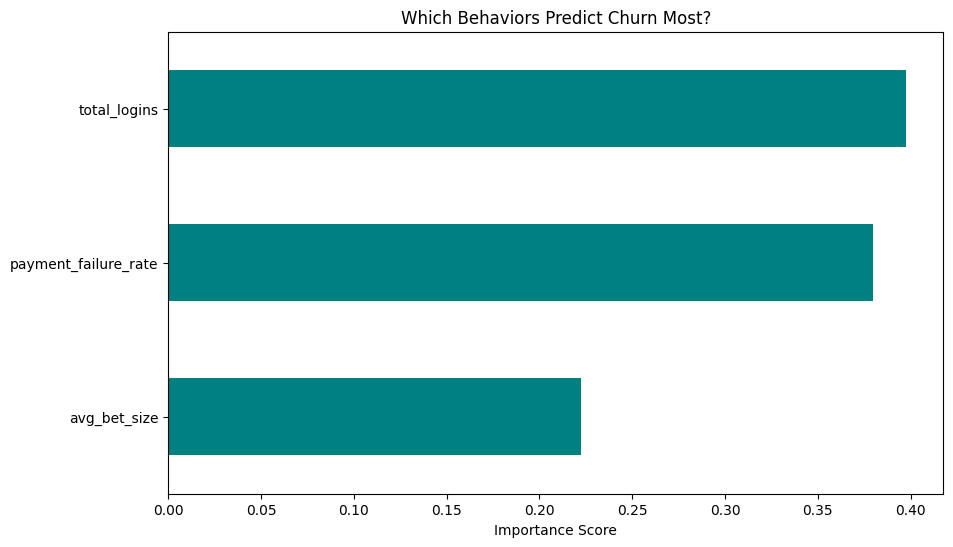

Numerical Feature Importance:
total_logins            0.397715
payment_failure_rate    0.379642
avg_bet_size            0.222643
dtype: float64


In [7]:
# Extract feature importance
importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='teal')
plt.title('Which Behaviors Predict Churn Most?')
plt.xlabel('Importance Score')
plt.show()

# Print numerical importance for the README
print("Numerical Feature Importance:")
print(importances.sort_values(ascending=False))

##### Breaking Down Results

1. The "Safety Net" (High Recall for Churned Players) Recall for class 1 (Churned) is 0.94.

    - What this means: model catches 94% of players who are actually going to leave.
    
    - Business Value: At Growe, it is better to "accidentally" give a bonus to a loyal player (False Positive) than
  
       to miss a player who is about to quit (False Negative). The model is a very effective safety net.

2. The "Predictive Power" (Precision) Precision for class 1 is 0.77.

    - What this means: When the model says "This player is churning," it is correct 77% of the time.
      This is a solid score for behavioral data, which is notoriously "noisy."

3. The Battle of Features

    - total_logins (39.7%) and payment_failure_rate (37.9%) are almost tied!
    
    - Insight: This proves that churn is a "Two-Headed Monster." Players leave because they lose interest (logins) AND
  
      because they get frustrated (failures).
    
    - Bet Size (22.2%) is the least important. This suggests that even "Whales" (big bettors) will churn if the payment system fails them.